In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
cnx = sqlite3.connect('data.db')

df = pd.read_sql_query("SELECT * FROM news", cnx)
df['fecha_publicacion'] = pd.to_datetime(df['fecha_publicacion'])

df.head()

,titulo,cuerpo,fecha_publicacion,diario,url,page
0,Campesino asesinado en Baraya,Un impacto en el pecho con una escopeta calibr...,2020-06-11 17:00:33,lanacion,https://www.lanacion.com.co/campesino-asesinad...,2
1,‘Morcilla’ a responder por homicidio de un jov...,Jorge Leonardo Pájaro Paredes conocido como ‘M...,2020-06-10 10:10:56,lanacion,https://www.lanacion.com.co/morcilla-a-respond...,2
2,Incautan 50 kilos de marihuana que eran transp...,"Las autoridades en el departamento del Huila, ...",2020-06-09 10:39:12,lanacion,https://www.lanacion.com.co/incautan-50-kilos-...,2
3,Miembros del CTI a juicio por robarse una bill...,A juicio fueron llamados Erney Ramírez Gordo y...,2020-06-08 19:30:53,lanacion,https://www.lanacion.com.co/miembros-del-cti-a...,2
4,"Militar neivano, una de las víctimas del fatal...",En la que fue su vivienda por muchos años en l...,2020-06-11 07:35:53,lanacion,https://www.lanacion.com.co/militar-neivano-un...,2


In [5]:
print('Número total de noticias: ', df.shape[0])
print('Número de diarios consultados: ', len(df.diario.unique()))
print('Diarios consultados: ', df.diario.unique())

Número total de noticias:  18987
Número de diarios consultados:  6
Diarios consultados:  ['lanacion' 'elpais' 'eldiario' 'elnuevodia' 'hoydiariodelmagdalena'
 'diariodelhuila']


In [6]:
df.groupby('diario').agg({'url': 'size','fecha_publicacion': ['min', 'max']})

url   fecha_publicacion                    
                        size                 min                 max
diario                                                              
diariodelhuila            46 2020-04-21 00:00:00 2020-06-12 00:00:00
eldiario                1319 2019-01-31 19:51:59 2020-06-12 00:00:43
elnuevodia               446 2020-01-13 11:02:33 2020-06-10 16:59:23
elpais                   140 2020-05-03 00:00:00 2020-06-12 00:00:00
hoydiariodelmagdalena   3713 2019-07-07 08:24:45 2020-06-12 17:43:36
lanacion               13323 2012-01-02 06:11:58 2020-06-11 17:00:33

In [44]:
df['dia_semana'] = df['fecha_publicacion'].dt.dayofweek

In [45]:
df1 = df.groupby('diario')['dia_semana'].value_counts()\
    .sort_values().reset_index(name='cuenta')
df1.head()

,diario,dia_semana,cuenta
0,diariodelhuila,5,2
1,diariodelhuila,6,2
2,diariodelhuila,0,3
3,diariodelhuila,2,8
4,diariodelhuila,3,8


(array([-2.,  0.,  2.,  4.,  6.,  8.]),
 <a list of 6 Text major ticklabel objects>)

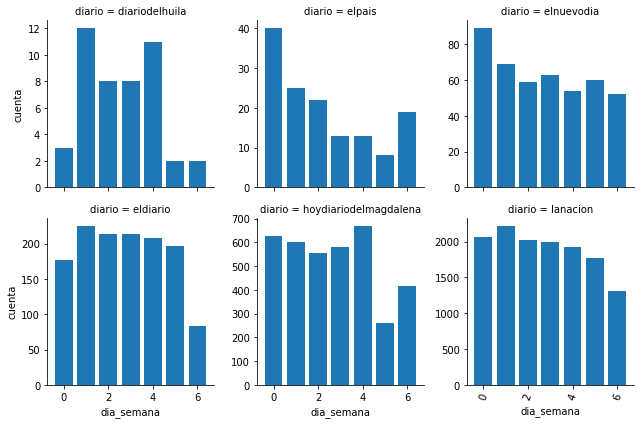

In [46]:
df['dia_semana'].value_counts().sort_values()
ficha = sns.FacetGrid(
    df1,
    col='diario',
    col_wrap=3,
    sharey=False
)
ficha.map(plt.bar, 'dia_semana', 'cuenta')

In [47]:
noticias_dia = df.query('fecha_publicacion.dt.hour < 12')
noticias_dia.head()

,titulo,cuerpo,fecha_publicacion,diario,url,page,dia_semana
1,‘Morcilla’ a responder por homicidio de un jov...,Jorge Leonardo Pájaro Paredes conocido como ‘M...,2020-06-10 10:10:56,lanacion,https://www.lanacion.com.co/morcilla-a-respond...,2,2
2,Incautan 50 kilos de marihuana que eran transp...,"Las autoridades en el departamento del Huila, ...",2020-06-09 10:39:12,lanacion,https://www.lanacion.com.co/incautan-50-kilos-...,2,1
4,"Militar neivano, una de las víctimas del fatal...",En la que fue su vivienda por muchos años en l...,2020-06-11 07:35:53,lanacion,https://www.lanacion.com.co/militar-neivano-un...,2,3
7,Roban $250 millones en atraco,Un nuevo hecho de inseguridad presentado el dí...,2020-06-10 07:50:34,lanacion,https://www.lanacion.com.co/roban-250-millones...,2,2
8,Hurtó dos motos en un mismo día en Neiva,"Sergio Stiven Zárate, fue detenido en flagranc...",2020-06-09 09:24:02,lanacion,https://www.lanacion.com.co/hurto-dos-motos-en...,2,1


In [51]:
df['long_cuerpo'] = df['cuerpo'].apply(lambda x: len(str(x).split()))
df['long_cuerpo'].value_counts().sort_values()

1527       1
1146       1
1130       1
970        1
922        1
        ... 
174       73
204       74
189       75
54        77
55      1174
Name: long_cuerpo, Length: 1091, dtype: int64

In [67]:
df['long_cuerpo'].describe()

count    18987.000000
mean       282.248749
std        199.299649
min          0.000000
25%        159.000000
50%        240.000000
75%        353.000000
max       3790.000000
Name: long_cuerpo, dtype: float64

In [111]:
import numpy as np

In [113]:
df['long_cuerpo'].quantile(np.arange(0, 1.05, 0.05))

0.00       0.0
0.05      55.0
0.10      89.0
0.15     121.0
0.20     142.0
0.25     159.0
0.30     175.0
0.35     190.0
0.40     206.0
0.45     222.0
0.50     240.0
0.55     259.0
0.60     277.0
0.65     297.0
0.70     324.0
0.75     353.0
0.80     389.0
0.85     437.0
0.90     506.4
0.95     636.7
1.00    3790.0
Name: long_cuerpo, dtype: float64

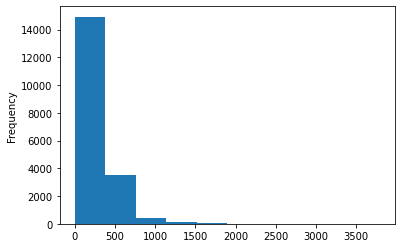

In [68]:
df['long_cuerpo'].plot.hist()

In [69]:
df2 = df.query('long_cuerpo<50')

In [70]:
df2.groupby('diario')['long_cuerpo'].value_counts()

diario                 long_cuerpo
diariodelhuila         23              1
                       41              1
                       44              1
eldiario               40              2
                       41              2
                       26              1
                       33              1
                       38              1
                       39              1
                       42              1
                       43              1
                       44              1
                       48              1
elnuevodia             24              1
                       26              1
                       28              1
                       29              1
                       39              1
                       42              1
                       47              1
hoydiariodelmagdalena  0              32
                       41              3
                       43              3
                      

In [60]:
df2['long_cuerpo'].describe()

count    2173.000000
mean       61.437644
std        19.201807
min         0.000000
25%        55.000000
50%        55.000000
75%        71.000000
max       100.000000
Name: long_cuerpo, dtype: float64

In [79]:
n = 3
print(
    "Titulo:", df2['titulo'].iloc[n],
    "\nDiario:", df2['diario'].iloc[n],
    "\nCuerpo:", df2['cuerpo'].iloc[n],
    "\nurl:", df2['url'].iloc[n],
)

Titulo: Capturas en La Virginia 
Diario: eldiario 
Cuerpo: En zona rural del municipio de La Virginia fueron capturadas tres personas por daños al medio ambiente, posteriormente fueron puestos a disposición de la autoridad competente por aprovechamiento ilícito de los recursos naturales….  
url: https://www.eldiario.com.co/judicial/editorwebeldiario-com-co/capturas-en-la-virginia/


In [93]:
df.query('diario=="eldiario"')['long_cuerpo'].value_counts()

55    1168
54      68
56      42
57      23
41       2
58       2
53       2
40       2
61       1
33       1
38       1
39       1
44       1
42       1
43       1
59       1
48       1
26       1
Name: long_cuerpo, dtype: int64

In [97]:
df1 = df.query('long_cuerpo<1000')
df1.groupby('diario')['long_cuerpo']\
    .value_counts().reset_index(name='cuenta')
df1['diario'].unique()

array(['lanacion', 'elpais', 'eldiario', 'elnuevodia',
       'hoydiariodelmagdalena', 'diariodelhuila'], dtype=object)

In [100]:
aux = df1.groupby('diario')['long_cuerpo'].value_counts().reset_index(name = 'cuenta')

In [102]:
aux.query('diario == "eldiario"')

,diario,long_cuerpo,cuenta
46,eldiario,55,1168
47,eldiario,54,68
48,eldiario,56,42
49,eldiario,57,23
50,eldiario,40,2
51,eldiario,41,2
52,eldiario,53,2
53,eldiario,58,2
54,eldiario,26,1
55,eldiario,33,1


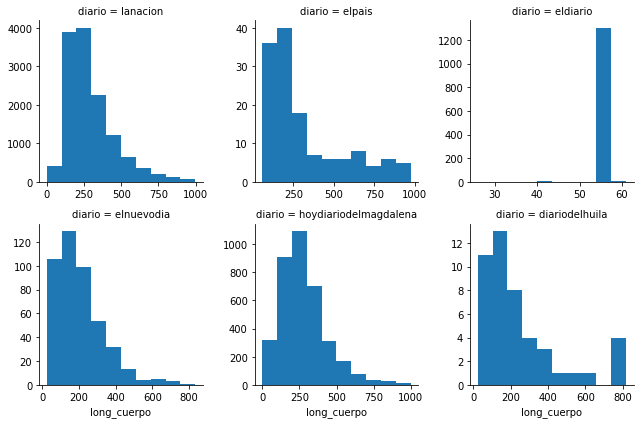

In [108]:
ficha = sns.FacetGrid(
    #df1.groupby('diario')['long_cuerpo']\
    #.value_counts().reset_index(name='cuenta'),
    df1,
    col='diario',
    col_wrap=3,
    sharey=False,
    sharex=False
)
ficha.map(plt.hist, 'long_cuerpo')